# Import libraries

In [ ]:
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
    
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2D, Reshape, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Activation, add
from keras.layers.core import Dropout, Activation
from keras.layers.advanced_activations import RELU, LeakyReLU
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras.models import Model, model_from_json
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras.utils.vis_utils import plot_model
from keras import regularizers
from keras import backend as K

import os
import numpy as np
import scipy.misc
import numpy.random as rng
from sklearn.utils import shuffle
import nibabel as nib 
import math
import glob
import tensorflow as tf

from skimage.transform import resize
from pathlib import Path
from matplotlib import pyplot as plt
import random 
from scipy.ndimage import zoom

%load_ext tensorboard
import tensorflow as tf
import datetime, os
!rm -rf ./logs/ 

!pip install elasticdeform
from scipy.ndimage.interpolation import shift
from scipy.ndimage import rotate
import imageio, elasticdeform

Using TensorFlow backend.


# Process KiTS19 dataset

In [ ]:
# in order to replicate the results, provide path to KiTS19 dataset

DATA_PATH = path_to_data

## Imaging - Experiment 1

In [ ]:
  for i in range(0,210):
    ct_path = DATA_PATH + "/case_{:05d}/".format(i)+"imaging.nii.gz"
    ct = nib.load(ct_path)
    ct = np.array(ct.dataobj)
    # Resize    
    ct = resize(ct, output_shape=[ct.shape[0],128,128], preserve_range=True, anti_aliasing=True)
    # Save
    print("Saving case_{:05d}".format(i))
    np.save(DATA_PATH + "/Experiment_1/imaging/case_{:05d}".format(i), ct)

## Segmentation

In [ ]:
for i in range(0,210):
    seg_path = DATA_PATH + "/case_{:05d}/".format(i)+"segmentation.nii.gz"
    seg = nib.load(seg_path)
    seg = np.array(seg.dataobj)
    # Resize
    seg = resize(seg, output_shape=[seg.shape[0],128,128], preserve_range=True, anti_aliasing=True)
    # Round
    seg_round = np.round(seg)
    # Binarize to tumor and kidney
    seg_binary = np.where(seg_round==2, 1, seg_round)
    # Save
    print("Saving case_{:05d}/".format(i)+"segmentation")
    np.save(DATA_PATH + "/Experiment_1/segmentation/case_{:05d}".format(i), seg_binary)
    np.histogram(seg_binary)

## Imaging - Experiment 2

In [ ]:
  for i in range(0,210):
    ct_path = DATA_PATH + "/case_{:05d}/".format(i)+"imaging.nii.gz"
    ct = nib.load(ct_path)
    ct = np.array(ct.dataobj)
    # Resize    
    ct = resize(ct, output_shape=[ct.shape[0],128,128], preserve_range=True, anti_aliasing=True)
    # Clip scan
    ct = np.clip(ct, -200, 500)
    # Save
    print("Saving case_{:05d}".format(i))
    np.save(DATA_PATH + "/Experiment_2/imaging/case_{:05d}".format(i), ct)

# Imaging - Experiment 3

In [ ]:
  for i in range(0,210):
    ct_clip = np.load(DATA_PATH + "/Experiment_2/imaging/case_{:05d}.npy".format(i))
    # Normalize
    max_value = np.max(ct_clip)
    min_value = np.min(ct_clip)
    ct_norm = (ct_clip - min_value) / (max_value - min_value)
    # Save
    print("Saving case_{:05d}".format(i))
    np.save(DATA_PATH + "/Experiment_3/imaging/case_{:05d}".format(i), ct_norm)

# Imaging - Experiment 4

In [ ]:
# Create list of random samples to apply augmentations to
augList =  np.random.randint(low=0, high=13533, size=4000)

In [ ]:
data_path = SAVE_PATH #path to which save to augmented data

In [ ]:
# Load data arrays from drive - Experiment 4   (data from experiment 2)
x_train = np.load(DATA_PATH + '/Experiment_2/data_arrays/x_train.npy')
y_train = np.load(DATA_PATH + '/Experiment_1/data_arrays/y_train.npy')

In [ ]:
# Function to perform elastic deformations
def deform_data(x_data, y_data, augList):
  x_deform_list = []
  y_deform_list = []
  for i in augList:
    [X_deformed, Y_deformed] = elasticdeform.deform_random_grid([x_train[i,:,:,-1], y_train[i,:,:,-1]],sigma=3, points=4, prefilter=True, mode='nearest', order=[0, 0])
    x_deform_list.append(X_deformed)
    y_deform_list.append(Y_deformed)
  x_deformed_data = np.asarray(x_deform_list)
  y_deformed_data = np.asarray(y_deform_list)
  x_deformed_data = x_deformed_data.reshape((x_deformed_data.shape[0],x_deformed_data.shape[1], x_deformed_data.shape[2],1))
  y_deformed_data = y_deformed_data.reshape((y_deformed_data.shape[0],y_deformed_data.shape[1], y_deformed_data.shape[2],1))
  np.save(data_path+'x_deform', x_deformed_data)
  np.save(data_path+'y_deform', y_deformed_data)
  return None

In [ ]:
np.save(data_path+'y_shift', y_shift)
np.save(data_path+'x_shift', x_shift)

In [ ]:
# Function to perform rotations
def rotate_data(data, augList, file_name):
  rotate_list = []
  for i in augList:
    rot = rotate(data[i,:,:,-1], angle=10, order = 0, mode = 'nearest', reshape=False, prefilter=True)
    rotate_list.append(rot)
  rotated_data = np.asarray(rotate_list)
  rotated_data = rotated_data.reshape((rotated_data.shape[0],rotated_data.shape[1], rotated_data.shape[2],1))
  return np.save(data_path+ file_name, rotated_data)

In [ ]:
def flip_data(data, augList, file_name):
  flip_list = []
  for i in augList:
    flip = np.flip(data[i,:,:,-1], axis=1)
    flip_list.append(flip)
  flipped_data = np.asarray(flip_list)
  flipped_data = flipped_data.reshape((flipped_data.shape[0],flipped_data.shape[1], flipped_data.shape[2],1))
  return np.save(data_path+ file_name, flipped_data)

In [ ]:
# Function to perform translations
def shift_data(x_data, y_data, augList, step):
  x_list = []
  y_list=[]
  for i in augList:
    img_shift = shift(x_data[i,:,:,-1], (step), order=0, mode='nearest', cval=0.0, prefilter=True)
    seg_shift = shift(y_data[i,:,:,-1], (step), order=0, mode='nearest', cval=0.0, prefilter=True)
    x_list.append(img_shift)
    y_list.append(seg_shift)
  x_data = np.asarray(x_list)
  y_data = np.asarray(y_list)
  x_data = x_data.reshape((x_data.shape[0],x_data.shape[1], x_data.shape[2],1))
  y_data = y_data.reshape((y_data.shape[0],y_data.shape[1], y_data.shape[2],1))
  np.save(data_path+'x_shift_'+str(step), x_data)
  np.save(data_path+'y_shift_'+str(step), y_data)
  return None

In [ ]:
rotate_data(x_train, augList[0:1000], 'x_rot')
rotate_data(y_train, augList[0:1000], 'y_rot')

In [ ]:
deform_data(x_train, y_train, augList[1000:2000])

In [ ]:
flip_data(y_train, augList[2000:3000], 'y_flip')
flip_data(x_train,augList[2000:3000], 'x_flip')

In [ ]:
shift_data(x_train, y_train, augList[3000:3250], (15,-15))
shift_data(x_train, y_train, augList[3250:3500] , (-15, 15))
shift_data(x_train, y_train, augList[3500:3750], (5, -20))
shift_data(x_train, y_train, augList[3750:4000], (-20, 5))

In [ ]:
y_shift_1 = np.load(data_path+'y_shift_(15, -15).npy')
y_shift_2 = np.load(data_path+'y_shift_(-15, 15).npy')
y_shift_3 = np.load(data_path+'y_shift_(5, -20).npy')
y_shift_4 = np.load(data_path+'y_shift_(-20, 5).npy')

y_shift = np.concatenate((y_shift_1,y_shift_3,y_shift_2,y_shift_4), axis=0)
np.save(data_path+'y_shift')

x_shift_1 = np.load(data_path+'x_shift_(15, -15).npy')
x_shift_2 = np.load(data_path+'x_shift_(-15, 15).npy')
x_shift_3 = np.load(data_path+'x_shift_(5, -20).npy')
x_shift_4 = np.load(data_path+'x_shift_(-20, 5).npy')

x_shift = np.concatenate((x_shift_1,x_shift_3,x_shift_2,x_shift_4), axis=0)
np.save(data_path+'x_shift')

# Define metric

In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
    return coef

## Custom metric

In [ ]:
def dice_coef_test(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    union = np.sum(y_true_f) + np.sum(y_pred_f)
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection) / union

In [ ]:
def create_weighted_binary_crossentropy(y_true, y_pred,zero_weight=0.011967271918916875, one_weight=0.9880327280810831):
  def weighted_binary_crossentropy(y_true, y_pred):
    b_ce = K.binary_crossentropy(y_true, y_pred)
    weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
    weighted_b_ce = weight_vector * b_ce
    return K.mean(weighted_b_ce)
    
  def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

  return weighted_binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)


# Build models

In [ ]:
def conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(1, 1), activation='relu', name=None):
    x = Conv2D(filters, (num_row, num_col), strides=strides, padding=padding, use_bias=False)(x)
    x = BatchNormalization(axis=3, scale=False)(x)

    if(activation == None):
        return x

    x = Activation(activation, name=name)(x)

    return x


def trans_conv2d_bn(x, filters, num_row, num_col, padding='same', strides=(2, 2), name=None):
    x = Conv2DTranspose(filters, (num_row, num_col), strides=strides, padding=padding)(x)
    x = BatchNormalization(axis=3, scale=False)(x)
    
    return x


def MultiResBlock(U, inp, alpha = 1.67):
    W = alpha * U

    shortcut = inp
    
    shortcut = conv2d_bn(shortcut, int(W*0.167) + int(W*0.333) +
                         int(W*0.5), 1, 1, activation=None, padding='same')

    conv3x3 = conv2d_bn(inp, int(W*0.167), 3, 3,
                        activation='relu', padding='same')
    
    conv5x5 = conv2d_bn(conv3x3, int(W*0.333), 3, 3,
                        activation='relu', padding='same')

    conv7x7 = conv2d_bn(conv5x5, int(W*0.5), 3, 3,
                        activation='relu', padding='same')

    out = concatenate([conv3x3, conv5x5, conv7x7], axis=3)
    out = BatchNormalization(axis=3)(out)

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    return out


def ResPath(filters, length, inp):
    shortcut = inp
    shortcut = conv2d_bn(shortcut, filters, 1, 1,
                         activation=None, padding='same')

    out = conv2d_bn(inp, filters, 3, 3, activation='relu', padding='same')

    out = add([shortcut, out])
    out = Activation('relu')(out)
    out = BatchNormalization(axis=3)(out)

    for i in range(length-1):

        shortcut = out
        shortcut = conv2d_bn(shortcut, filters, 1, 1,
                             activation=None, padding='same')

        out = conv2d_bn(out, filters, 3, 3, activation='relu', padding='same')

        out = add([shortcut, out])
        out = Activation('relu')(out)
        out = BatchNormalization(axis=3)(out)

    return out


def MultiResUnet(height, width, n_channels):
    inputs = Input((height, width, n_channels))

    mresblock1 = MultiResBlock(32, inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(mresblock1)
    mresblock1 = ResPath(32, 4, mresblock1)

    mresblock2 = MultiResBlock(32*2, pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(mresblock2)
    mresblock2 = ResPath(32*2, 3, mresblock2)

    mresblock3 = MultiResBlock(32*4, pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(mresblock3)
    mresblock3 = ResPath(32*4, 2, mresblock3)

    mresblock4 = MultiResBlock(32*8, pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(mresblock4)
    mresblock4 = ResPath(32*8, 1, mresblock4)

    mresblock5 = MultiResBlock(32*16, pool4)

    up6 = concatenate([Conv2DTranspose(
        32*8, (2, 2), strides=(2, 2), padding='same')(mresblock5), mresblock4], axis=3)
    mresblock6 = MultiResBlock(32*8, up6)

    up7 = concatenate([Conv2DTranspose(
        32*4, (2, 2), strides=(2, 2), padding='same')(mresblock6), mresblock3], axis=3)
    mresblock7 = MultiResBlock(32*4, up7)

    up8 = concatenate([Conv2DTranspose(
        32*2, (2, 2), strides=(2, 2), padding='same')(mresblock7), mresblock2], axis=3)
    mresblock8 = MultiResBlock(32*2, up8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(
        2, 2), padding='same')(mresblock8), mresblock1], axis=3)
    mresblock9 = MultiResBlock(32, up9)

    conv10 = conv2d_bn(mresblock9,1 , 1, 1, activation='sigmoid')
    
    model = Model(inputs=[inputs], outputs=[conv10])

    return model

In [ ]:
def build_unet(shape):
	input_layer = Input(shape = shape)

	conv = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(input_layer)
	conv = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv)
	pool = MaxPooling2D(pool_size = (2, 2))(conv)

	conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv)
	conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
	pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

	conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1)
	conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
	pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

	conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2)
	conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
	pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

	conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(pool3)
	conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
	pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

	conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(pool4)
	conv5 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same')(conv5)

	up6 = concatenate([Conv2DTranspose(256, (2, 2), strides = (2, 2), padding = 'same')(conv5), conv4], axis = 3)
	conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(up6)
	conv6 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv6)

	up7 = concatenate([Conv2DTranspose(128, (2, 2), strides = (2, 2), padding = 'same')(conv6), conv3], axis = 3)
	conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(up7)
	conv7 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv7)

	up8 = concatenate([Conv2DTranspose(64, (2, 2), strides = (2, 2), padding = 'same')(conv7), conv2], axis = 3)
	conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(up8)
	conv8 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv8)

	up9 = concatenate([Conv2DTranspose(32, (2, 2), strides = (2, 2), padding = 'same')(conv8), conv1], axis = 3)
	conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up9)
	conv9 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv9)

	conv10 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv9)
	conv10 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')(conv10)

	conv11 = Conv2D(1, (1, 1), activation = 'sigmoid')(conv10)

	return Model(input_layer, conv11)

# Load data fom drive

## Train, val, test split

In [ ]:
train =[96, 116, 44, 21, 144, 65, 208, 108, 132, 115, 28, 72, 122, 80, 19, 197, 195, 161, 10, 112, 129, 166, 54, 151, 34, 87, 27, 142, 14, 86, 104, 66, 90, 179, 43, 164, 29, 178, 79, 182, 71, 35, 173, 95, 26, 4, 160, 119, 52, 159, 25, 187, 126, 7, 186, 128, 155, 163, 57, 48, 174, 200, 131, 130, 53, 106, 150, 12, 103, 31, 93, 141, 183, 40, 49, 139, 55, 60, 201, 59, 42, 88, 176, 137, 193, 58, 143, 199, 32, 41, 83, 140, 46, 100, 120, 18, 24, 33, 30, 169, 85, 162, 148, 110, 63, 181, 171, 124, 38, 56, 156, 8, 191, 17, 168, 203, 13, 111, 177, 184, 207, 101, 73, 11, 1, 76, 84, 5, 6, 2, 202, 189, 51, 149, 152, 185, 136, 89, 134, 97, 167, 61, 109, 175, 107, 145, 157, 188, 77, 0, 209, 20, 47, 92, 102, 75, 113, 170, 9, 50, 39, 99, 127, 81, 154, 114, 16]
val =[165, 192, 15, 180, 70, 196, 198, 194, 105, 118, 206, 205, 37, 146, 45, 153, 121, 62, 78, 98]
test =[204, 138, 74, 67, 147, 22, 123, 64, 117, 94, 3, 82, 135, 91, 158, 36, 172, 69, 190]

In [ ]:
# Load data: skip empty slices except for 5 each case

def load_skip_empty(experiment, data_sort,data_list,saving_format):
  data_array = np.zeros([1,128,128])
  dataList = []
  for i in data_list:
    # Load scan or segmentation
    data_loaded = np.load(DATA_PATH + experiment + data_sort + "/case_{:05d}".format(i)+".npy")
    # Load segmentation 
    check = np.load(DATA_PATH + "/Experiment_1/segmentation/case_{:05d}".format(i)+".npy")
    # Check for empty slices, save non-empty to list
    countList=[]
    for j in range(check.shape[0]):
      if np.sum(check[j,:,:])!=0:
        countList.append(j)
    # Reshape along z-axis with non-empty slices +10
    min_slice = min(countList) - 5
    max_slice = max(countList) + 5
    z,x,y = data_loaded.shape
    data_loaded = data_loaded[min_slice:max_slice,:,:]
    # Add to array
    data_array = np.concatenate((data_array, data_loaded), axis=0)
    print("Case", i,'is loaded.')
  data_array_r = data_array.reshape((data_array.shape[0],data_array.shape[1], data_array.shape[2],1))
  return np.save(DATA_PATH + experiment + '/data_arrays' + saving_format, data_array_r)

In [ ]:
# Example of loading cases for experiment 1 and split them in train, validation and test set

load_skip_empty('/Experiment_1', '/imaging', train, '/x_train')
load_skip_empty('/Experiment_1','/segmentation', train, '/y_train')
load_skip_empty('/Experiment_1','/imaging', val, '/x_val')
load_skip_empty('/Experiment_1','/segmentation', val, '/y_val')
load_skip_empty('/Experiment_1','/imaging', test, '/x_test')
load_skip_empty('/Experiment_1','/segmentation', test, '/y_test')

## Load data arrays

In [ ]:
def load_aug(data):
  return np.load(data_path+data+'.npy')

In [ ]:
# Load data arrays - Experiment 4

x_train= np.load(DATA_PATH +'/Experiment_2/data_arrays/x_train.npy')
y_train = np.load(DATA_PATH +'/Experiment_1/data_arrays/y_train.npy')

x_val= np.load(DATA_PATH +'/Experiment_2/data_arrays/x_val.npy')
y_val = np.load(DATA_PATH +'/Experiment_1/data_arrays/y_val.npy')

x_def = load_aug('x_deform')
y_def = load_aug('y_deform')

x_shift = load_aug('x_shift')
y_shift = load_aug('y_shift')

x_flip = load_aug('x_flip')
y_flip = load_aug('y_flip')

x_rot = load_aug('x_rot')
y_rot = load_aug('y_rot')


In [ ]:
x_train = np.concatenate((x_train, x_flip, x_rot, x_shift, x_def),axis=0)
y_train = np.concatenate((x_train, y_flip, y_rot, y_shift, y_def),axis=0)

In [ ]:
# Load data arrays from drive - Experiment 3

x_train = np.load((DATA_PATH +'/Experiment_3/data_arrays/x_train.npy')
y_train = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_train.npy')

x_val = np.load((DATA_PATH +'/Experiment_3/data_arrays/x_val.npy')
y_val = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_val.npy')

In [ ]:
# Load data arrays from drive - Experiment 2

x_train = np.load((DATA_PATH +'/Experiment_2/data_arrays/x_train.npy')
y_train = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_train.npy')

x_val = np.load((DATA_PATH +'/Experiment_2/data_arrays/x_val.npy')
y_val = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_val.npy')

In [ ]:
# Load data arrays from drive - Experiment 2b

x_train = np.load((DATA_PATH +'/Experiment_2/data_arrays/x_train.npy')
y_train = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_train.npy')

x_val = np.load((DATA_PATH +'/Experiment_2/data_arrays/x_val.npy')
y_val = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_val.npy')

In [ ]:
# Load data arrays from drive - Experiment 1

x_train = np.load((DATA_PATH +'/Experiment_1/data_arrays/x_train.npy')
y_train = np.load(DATA_PATH +'/Experiment_1/data_arrays/y_train.npy')

x_val = np.load((DATA_PATH +'/Experiment_1/data_arrays/x_val.npy')
y_val = np.load((DATA_PATH +'/Experiment_1/data_arrays/y_val.npy')

# Define callbacks

In [ ]:
# Define which model to run which experiment on
test_model = '/unet'
test_experiment = '/Results_exp4'

log_dir = DATA_PATH+test_model+test_experiment + datetime.datetime.now().strftime("%Y-%m-%d %H")

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

weight_saver = ModelCheckpoint(log_dir + '/{epoch:03d}-{val_loss:.3f}.hdf5', 
                               monitor = 'val_loss',
                               save_best_only = True, mode = 'min', save_weights_only = True)

reduce_lr_on_plateau = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 3, verbose = 1, 
                                          mode = 'min', cooldown = 2, min_lr = 1e-6)

early = EarlyStopping(monitor = "val_loss", mode = "min", patience = 30)

csv_logger = CSVLogger(log_dir+'/log.csv', append=True, separator=';')

# Train model

In [ ]:
# Experiment 4 - U-Net

model = build_unet((128,128,1))
model.compile(optimizer = Adam(lr = 1e-4), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
model.load_weights(DATA_PATH+test_model+test_experiment + '/2020-06-14 17/026-0.108.hdf5')
model.fit(x_train, y_train, batch_size=32, validation_data= (x_val, y_val),shuffle=True, epochs=200, verbose = 1, 
                          callbacks=[tensorboard_callback, weight_saver, reduce_lr_on_plateau, csv_logger, early])

Train on 16533 samples, validate on 1529 samples
Epoch 1/200
16533/16533 [==============================] - 122s 7ms/step - loss: 0.0712 - dice_coef: 0.9332 - val_loss: 0.1072 - val_dice_coef: 0.9013
Epoch 2/200
16533/16533 [==============================] - 112s 7ms/step - loss: 0.0618 - dice_coef: 0.9418 - val_loss: 0.0970 - val_dice_coef: 0.9091
Epoch 3/200
16533/16533 [==============================] - 114s 7ms/step - loss: 0.0552 - dice_coef: 0.9480 - val_loss: 0.0920 - val_dice_coef: 0.9142
Epoch 4/200
16533/16533 [==============================] - 113s 7ms/step - loss: 0.0518 - dice_coef: 0.9511 - val_loss: 0.0948 - val_dice_coef: 0.9131
Epoch 5/200
16533/16533 [==============================] - 114s 7ms/step - loss: 0.0495 - dice_coef: 0.9533 - val_loss: 0.0992 - val_dice_coef: 0.9070
Epoch 6/200
16533/16533 [==============================] - 114s 7ms/step - loss: 0.0522 - dice_coef: 0.9508 - val_loss: 0.0960 - val_dice_coef: 0.9113

Epoch 00006: ReduceLROnPlateau reducing lear

# Predict output

All predictions are made on the test set equally processed as the train and validation set.

### Experiment 4

In [ ]:
model = build_unet((128,128,1))
model.load_weights(DATA_PATH+test_model+test_experiment + '/2020-06-20 09/015-0.090.hdf5')
model.compile(optimizer = Adam(lr =  1e-06), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
pred_4 = model.predict(x_test)
np.save(DATA_PATH+test_model+test_experiment+'/prediction',pred_4)

In [ ]:
# Dice Coefficient on the model trained with augmented data of Stage 1

dice_coef_test(y_test,pred_4)

0.9346971614031981

### Experiment 3

In [ ]:
model = build_unet((128,128,1))
model.load_weights(DATA_PATH+test_model+test_experiment +'/2020-06-18 10/009-0.097.hdf5')
model.compile(optimizer = Adam(lr = 1.25e-05), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
pred_3 = model.predict(x_test)

dice_coef_test(y_test,pred_3)

0.8796359286831191

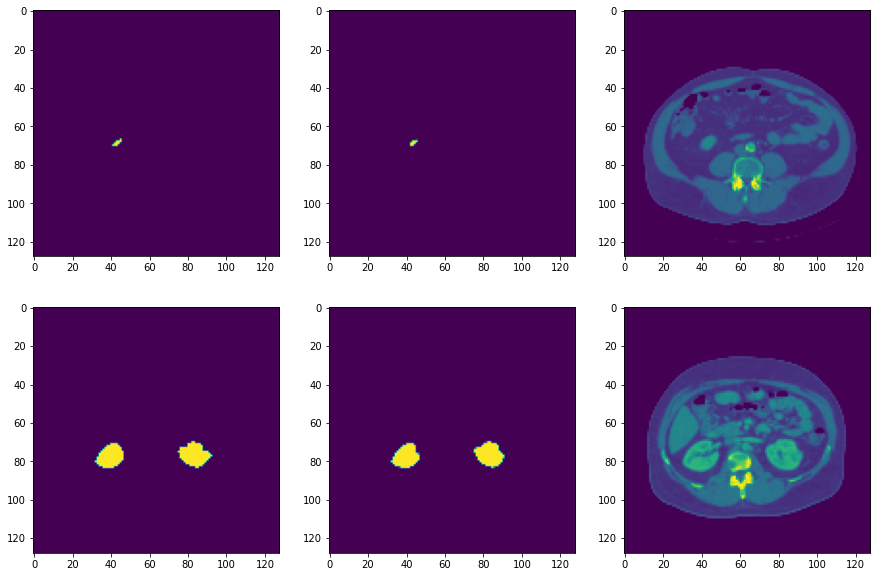

In [ ]:
# Example of predicted output and the ground truth

plt.figure(figsize=(15,10))

plt.subplot(2,3,1)
plt.imshow(y_test[46,:,:,-1])

plt.subplot(2,3,2)
plt.imshow(pred_3[46,:,:,-1])

plt.subplot(2,3,3)
plt.imshow(x_test[46,:,:,-1])

plt.subplot(2,3,4)
plt.imshow(y_test[588,:,:,-1])

plt.subplot(2,3,5)
plt.imshow(pred_3[588,:,:,-1])

plt.subplot(2,3,6)
plt.imshow(x_test[588,:,:,-1])

### Experiment 2

In [ ]:
model = build_unet((128,128,1))
model.load_weights(DATA_PATH+test_model+test_experiment + '/2020-06-17 14/054-0.174.hdf5')
model.compile(optimizer = Adam(lr = 1.25e-05), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
pred_2b = model.predict(x_test)

dice_coef_test(y_test,pred_2b)

0.8288762892907959

### Experiment 2b

In [ ]:
model = build_unet((128,128,1))
model.load_weights(DATA_PATH+test_model+test_experiment +'/2020-06-14 17/026-0.108.hdf5')
model.compile(optimizer = Adam(lr = 1e-4), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
pred_2 = model.predict(x_test)

dice_coef_test(y_test,pred_2)

0.9004754507886081

### Experiment 1

In [ ]:
model = build_unet((128,128,1))
model.load_weights(DATA_PATH+test_model+test_experiment + '/2020-06-26 08/017-0.117.hdf5')
model.compile(optimizer = Adam(lr = 1e-6), loss = create_weighted_binary_crossentropy, metrics = [dice_coef])
pred_1 = model.predict(x_test)

dice_coef_test(y_test,pred_1)

0.884654005125076